In [1]:
!pip install pymannkendall

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [51]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

super_count_cols = ['people'+'_counts', 'small_vehicles'+'_counts', 'two_wheelers'+'_counts', 'large_vehicles'+'_counts', 'refuse'+'_counts', 'market'+'_counts', 'animal'+'_counts']

all_count_cols = count_cols + super_count_cols

vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

site_names = {'AD': 'Asylum Down',
             'ASH' : 'Ashaiman',
             'EL': 'East Legon',
             'JT' : 'James Town',
             'LA': 'Labadi',
             'N1W': 'N1 West Motorway',
             'NM': 'Nima',
             'TF': 'Taifa',
             'TMW': 'Tema Motorway',
             'UGH': 'University of Ghana'}

# Define super categories
super_categories = {
    'people': ['person', 'vendor'],
    'small_vehicles': ['car', 'taxi', 'truck'],
    'two_wheelers': ['bicycle', 'motorcycle'],
    'large_vehicles': ['trotro', 'van', 'lorry', 'bus'],
    'refuse': ['trash', 'debris'],
    'market': ['umbrella', 'stall', 'bowl', 'food'],
    'animal': ['animal']
}

In [3]:
# # Load the model coefficients from the CSV file
# site = 'ASH'
# model_df = pd.read_csv(f'./{site}_model_coefficients.csv')



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to combine main and interaction effects
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef, main_lower, main_upper = calculate_effects_and_ci(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef, inter_lower, inter_upper = calculate_effects_and_ci(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
        combined_lower = np.exp(np.log(main_lower) + np.log(inter_lower))
        combined_upper = np.exp(np.log(main_upper) + np.log(inter_upper))
    else:
        combined_estimate, combined_lower, combined_upper = main_coef, main_lower, main_upper
    
    return combined_estimate, combined_lower, combined_upper

# Function to plot total hour effects
def plot_total_hour_effects(model_df, hour_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for hour in range(1, 24):
        main_term = f'hour{hour}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(hour_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Hour Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(hour_labels)), labels=hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_hour_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total day effects, including interaction terms
def plot_total_day_effects(model_df, day_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for day_idx, day in enumerate(day_labels, start=1):
        if day == 'Mon':
            # For Monday, no interaction effect
            estimates.append(1)
            lower_bounds.append(1)
            upper_bounds.append(1)
        else:
            main_term = f'day{day_idx}'
            main_row = model_df[model_df['term'] == main_term]
            
            interaction_estimates = []
            interaction_lowers = []
            interaction_uppers = []
            
            # Combine hour interaction effects for the given day
            for hour in range(1, 24):
                interaction_term = f'hour{hour}:day{day_idx}'
                interaction_row = model_df[model_df['term'] == interaction_term]
                
                if not main_row.empty and not interaction_row.empty:
                    combined_estimate, combined_lower, combined_upper = combine_main_and_interaction_effects(
                        main_row.iloc[0], interaction_row
                    )
                    interaction_estimates.append(combined_estimate)
                    interaction_lowers.append(combined_lower)
                    interaction_uppers.append(combined_upper)
            
            if interaction_estimates:
                avg_estimate = np.mean(interaction_estimates)
                avg_lower = np.mean(interaction_lowers)
                avg_upper = np.mean(interaction_uppers)
                estimates.append(avg_estimate)
                lower_bounds.append(avg_lower)
                upper_bounds.append(avg_upper)
            else:
                estimates.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(day_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Day Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(day_labels)), labels=day_labels, rotation=45)
    plt.xlabel('Day of Week')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_day_effects.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 

for site in sites:
    for super_category in super_categories:
        model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
        
        # Plot total hour effects
        hour_labels = [f'Hour {i}' for i in range(1, 24)]
        plot_total_hour_effects(
            model_df, 
            hour_labels, 
            f'Total Effect of Hour on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )
        
        # Plot total day effects
        day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        plot_total_day_effects(
            model_df, 
            day_labels, 
            f'Total Effect of Day on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to plot total year effects
def plot_total_year_effects(model_df, year_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = [1]  # Adding the reference category (2019) with an effect of 1
    lower_bounds = [1]  # The lower bound for the reference category
    upper_bounds = [1]  # The upper bound for the reference category
    
    for year in year_labels:
        main_term = f'year{year}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Include '2019' in the labels for the reference category
    year_labels = ['2019'] + year_labels
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(year_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Year Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(year_labels)), labels=year_labels, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_year_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total week effects
def plot_total_week_effects(model_df, week_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = [1]  # Adding the reference category (Week 1) with an effect of 1
    lower_bounds = [1]  # The lower bound for the reference category
    upper_bounds = [1]  # The upper bound for the reference category
    
    for week in range(2, 54):  # Start from week 2, since week 1 is the reference
        main_term = f'week{week}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Include 'Week 1' in the labels for the reference category
    week_labels = ['Week 1'] + week_labels
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(week_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Week Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(week_labels)), labels=week_labels, rotation=45)
    plt.xlabel('Week')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_week_effects.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 

for site in sites:
    for super_category in super_categories:
        model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
        
        # Plot total year effects
        year_labels = ['2020', '2021', '2022', '2023', '2024']  # Assuming '2019' as the reference
        plot_total_year_effects(
            model_df, 
            year_labels, 
            f'Total Effect of Year on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )
        
        # Plot total week effects
        week_labels = [f'Week {i}' for i in range(2, 54)]  # Week 1 is the reference category
        plot_total_week_effects(
            model_df, 
            week_labels, 
            f'Total Effect of Week on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import spearmanr
import pymannkendall as mk  # Mann-Kendall test library
from scipy.stats import wilcoxon  # Import Wilcoxon test

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to calculate average percentage change
def calculate_avg_percentage_change(estimates):
    # Remove NaNs from estimates
    estimates = estimates[~np.isnan(estimates)]
    if len(estimates) < 2:
        return np.nan
    year_on_year_diff = np.diff(estimates)
    if len(year_on_year_diff) == 0:
        return np.nan
    # Calculate the average year-on-year percentage change
    avg_diff_percentage = (np.mean(year_on_year_diff) / np.mean(estimates[:-1])) * 100  # Overall percentage change
    return avg_diff_percentage

# Modified check_trend function to return detailed information
def check_trend(estimates, method='spearman'):
    # Remove NaNs from estimates
    estimates = estimates[~np.isnan(estimates)]
    if len(estimates) < 2:
        return {
            'direction': None,
            'p_value': None,
            'avg_percentage_change': np.nan,
            'is_significant': False
        }

    year_values = np.arange(len(estimates))
    correction_factor = 10
    alpha = 0.05 / correction_factor
    avg_percentage_change = calculate_avg_percentage_change(estimates)

    direction = None
    is_significant = False
    p_value = None

    if method == 'spearman':
        # Perform Spearman correlation and return trend direction
        corr, p_value = spearmanr(year_values, estimates)
        if p_value < alpha:
            is_significant = True
        if corr > 0:
            direction = 'up'
        elif corr < 0:
            direction = 'down'
    elif method == 'mannkendall':
        mk_result = mk.original_test(estimates)
        p_value = mk_result.p
        if p_value < alpha:
            is_significant = True
        if mk_result.trend == 'increasing':
            direction = 'up'
        elif mk_result.trend == 'decreasing':
            direction = 'down'
    elif method == 'wilcoxon':
        # Calculate year-on-year differences
        year_on_year_diff = np.diff(estimates)
        if len(year_on_year_diff) < 1:
            return {
                'direction': None,
                'p_value': None,
                'avg_percentage_change': avg_percentage_change,
                'is_significant': False
            }
        # Perform Wilcoxon Signed-Rank Test
        wilcoxon_stat, p_value = wilcoxon(year_on_year_diff)
        if p_value < alpha:
            is_significant = True
        if np.mean(year_on_year_diff) > 0:
            direction = 'up'
        elif np.mean(year_on_year_diff) < 0:
            direction = 'down'
    else:
        raise ValueError(f"Unknown method: {method}")

    return {
        'direction': direction,
        'p_value': p_value,
        'avg_percentage_change': avg_percentage_change,
        'is_significant': is_significant
    }

# Modified plotting function
def plot_total_year_effects_all_sites_with_trends(sites, super_category, year_labels, title, trend_method='spearman'):
    plt.figure(figsize=(12, 6))

    # Get the colormap using the updated method
    colormap = plt.colormaps['tab10']
    colors = [colormap(i) for i in range(len(sites))]

    all_estimates = []  # To track all central estimates for y-axis scaling
    label_positions = []  # To keep track of label positions
    trend_info_list = []  # To store trend information for each site

    for idx, site in enumerate(sites):
        # Load the model data for the current site and category
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue

        model_df = pd.read_csv(filepath)

        estimates = [1]  # Adding the reference category (2019) with an effect of 1
        lower_bounds = [1]  # The lower bound for the reference category
        upper_bounds = [1]  # The upper bound for the reference category

        # Iterate over the year labels to extract coefficients
        for year in year_labels:
            main_term = f'year{year}'
            row = model_df[model_df['term'] == main_term]

            if not row.empty:
                coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
                estimates.append(coef)
                lower_bounds.append(lower)
                upper_bounds.append(upper)
            else:
                estimates.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)

        # Include '2019' in the labels for the reference category
        full_year_labels = ['2019'] + year_labels

        # Convert lists to numpy arrays
        estimates = np.array(estimates)
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)

        # Keep track of all central estimates for setting y-axis limits later
        all_estimates.extend(estimates[~np.isnan(estimates)])

        # Compute trend_info
        trend_info = check_trend(estimates, method=trend_method)

        # Store in trend_info_list
        trend_info_list.append({
            'site': site,
            'trend_info': trend_info,
            'estimates': estimates,
            'lower_bounds': lower_bounds,
            'upper_bounds': upper_bounds,
            'colors_idx': idx,
            'full_year_labels': full_year_labels
        })

    # Plotting all sites
    for info in trend_info_list:
        estimates = info['estimates']
        lower_bounds = info['lower_bounds']
        upper_bounds = info['upper_bounds']
        trend_info = info['trend_info']
        idx = info['colors_idx']
        full_year_labels = info['full_year_labels']
        site = info['site']

        # For significant trends, adjust plotting parameters
        if trend_info['is_significant']:
            zorder_line = 4
            zorder_marker = 4
            linewidth = 6
            markersize = 12
            alpha_line = 1
            alpha_marker = 1

            # Plot the white shadow effect behind the main lines and markers
            plt.plot(
                range(len(full_year_labels)),
                estimates,
                color='white',
                linestyle='-',
                linewidth=linewidth + 4,
                alpha=1,
                zorder=zorder_line - 1
            )
            plt.errorbar(
                range(len(full_year_labels)),
                estimates,
                yerr=None,
                fmt='o',
                color='white',
                markersize=markersize + 4,
                alpha=1,
                zorder=zorder_marker - 1
            )
        else:
            # Default plotting parameters
            zorder_line = 2
            zorder_marker = 2
            linewidth = 2
            markersize = 8
            alpha_line = 0.5
            alpha_marker = 0.5

        # Plot the whiskers (error bars)
        plt.errorbar(
            range(len(full_year_labels)),
            estimates,
            yerr=[estimates - lower_bounds, upper_bounds - estimates],
            fmt='none',
            ecolor=colors[idx],
            alpha=0.125,
            capsize=5,
            elinewidth=1.5,
            zorder=zorder_line - 1
        )

        # Plot lines connecting the points
        plt.plot(
            range(len(full_year_labels)),
            estimates,
            color=colors[idx],
            linestyle='-',
            linewidth=linewidth,
            alpha=alpha_line,
            zorder=zorder_line
        )

        # Plot the central points
        plt.errorbar(
            range(len(full_year_labels)),
            estimates,
            yerr=None,
            fmt='o',
            color=colors[idx],
            capsize=5,
            markersize=markersize,
            alpha=alpha_marker,
            elinewidth=1.5,
            label=f'{site_names[site]}',
            zorder=zorder_marker
        )

    labels_plotted = 0  # Initialize labels plotted count
    max_labels = 3      # Maximum number of labels to plot

    # First, process significant trends
    significant_trends = [info for info in trend_info_list if info['trend_info']['is_significant']]

    # Plot labels for significant trends
    for info in significant_trends:
        if labels_plotted >= max_labels:
            break  # Do not plot more than max_labels

        estimates = info['estimates']
        trend_info = info['trend_info']
        idx = info['colors_idx']
        site = info['site']
        full_year_labels = info['full_year_labels']

        # Prepare label text
        p_value = trend_info['p_value']
        if p_value is None:
            p_value_formatted = "(p=N/A)"
        elif p_value < 0.01:
            p_value_formatted = "(p<0.01)"
        else:
            p_value_formatted = f"(p={p_value:.2f})"
        avg_percentage_change_formatted = f"{trend_info['avg_percentage_change']:.3g}%"
        arrow = '▲' if trend_info['direction'] == 'up' else '▼'
        label_text = f"{arrow} {p_value_formatted} {avg_percentage_change_formatted}"

        # Determine initial label position
        label_x = len(full_year_labels) - 0.8
        label_y = estimates[-1]

        # Adjust label position to avoid overlap
        if all_estimates:
            max_estimate = max(all_estimates)
            min_estimate = min(all_estimates)
            y_range = max_estimate - min_estimate
            threshold = y_range * 0.05  # 5% of y-range
        else:
            threshold = 0.1  # Default value

        offset_x = 1.5  # Amount to move label to the right

        # Check for overlapping labels
        overlap_count = 0
        for existing_label in label_positions:
            existing_label_y = existing_label['y']
            if abs(label_y - existing_label_y) < threshold:
                overlap_count += 1

        label_x += offset_x * overlap_count

        # Draw a thin line (connector) if label is offset
        if overlap_count > 0:
            plt.plot([len(full_year_labels) - 1, label_x], [label_y, label_y],
                     color=colors[idx], linestyle='-', linewidth=1, zorder=4)

        # Add this label position to the list
        label_positions.append({'x': label_x, 'y': label_y})

        # Annotate the final year value with the arrow, p-value, and percentage change
        plt.text(label_x, label_y, label_text,
                 color=colors[idx], fontsize=12, va='center', ha='left', zorder=4, bbox=dict(facecolor='white', alpha=0.8))

        labels_plotted += 1

    # Now, process non-significant trends, but only if labels_plotted < max_labels
    remaining_labels = max_labels - labels_plotted

    if remaining_labels > 0:
        non_significant_trends = [info for info in trend_info_list if not info['trend_info']['is_significant']]
        # Filter out trends with NaN avg_percentage_change
        non_significant_trends = [info for info in non_significant_trends if not np.isnan(info['trend_info']['avg_percentage_change'])]

        # Sort by absolute value of avg_percentage_change, descending
        non_significant_trends_sorted = sorted(non_significant_trends, key=lambda x: abs(x['trend_info']['avg_percentage_change']), reverse=True)

        # Select top remaining_labels
        top_non_sig_trends = non_significant_trends_sorted[:remaining_labels]

        for info in top_non_sig_trends:
            if labels_plotted >= max_labels:
                break  # Do not plot more than max_labels labels

            estimates = info['estimates']
            trend_info = info['trend_info']
            idx = info['colors_idx']
            site = info['site']
            full_year_labels = info['full_year_labels']

            # Prepare label text
            p_value = trend_info['p_value']
            if p_value is None:
                p_value_formatted = "(p=N/A)"
            elif p_value < 0.01:
                p_value_formatted = "(p<0.01)"
            else:
                p_value_formatted = f"(p={p_value:.2f})"
            avg_percentage_change_formatted = f"{trend_info['avg_percentage_change']:.3g}%"
            arrow = '▲' if trend_info['direction'] == 'up' else '▼'
            label_text = f"{arrow} {p_value_formatted} {avg_percentage_change_formatted}"

            # Determine initial label position
            label_x = len(full_year_labels) - 0.8
            label_y = estimates[-1]

            # Adjust label position to avoid overlap
            if all_estimates:
                max_estimate = max(all_estimates)
                min_estimate = min(all_estimates)
                y_range = max_estimate - min_estimate
                threshold = y_range * 0.05  # 5% of y-range
            else:
                threshold = 0.1  # Default value

            offset_x = 1.5  # Amount to move label to the right

            # Check for overlapping labels
            overlap_count = 0
            for existing_label in label_positions:
                existing_label_y = existing_label['y']
                if abs(label_y - existing_label_y) < threshold:
                    overlap_count += 1

            label_x += offset_x * overlap_count

            # Draw a thin line (connector) if label is offset
            if overlap_count > 0:
                plt.plot([len(full_year_labels) - 1, label_x], [label_y, label_y],
                         color=colors[idx], linestyle='-', linewidth=1, zorder=3)

            # Add this label position to the list
            label_positions.append({'x': label_x, 'y': label_y})

            # Annotate the final year value with the arrow, p-value, and percentage change
            plt.text(label_x, label_y, label_text,
                     color=colors[idx], fontsize=12, va='center', ha='left', zorder=3, bbox=dict(facecolor='white', alpha=0.8))

            labels_plotted += 1

    # Removing gridlines and adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)

    # Adding a thicker black line at y=1 to represent the reference level
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')

    # Set the y-axis limits
    if all_estimates:
        max_estimate = max(all_estimates)
        plt.ylim(0, max_estimate * 1.1)

    # Setting x-ticks with labels
    plt.xticks(ticks=range(len(full_year_labels)), labels=full_year_labels, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.legend(loc='upper left')

    # Create directory if it doesn't exist
    output_dir = './results/time_series_by_category/year/'
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_year_effects_{super_category}.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for super_category in super_categories:
    # Plot total year effects for all sites, including trend annotations
    year_labels = ['2020', '2021', '2022', '2023', '2024']  # Assuming '2019' as the reference
    plot_total_year_effects_all_sites_with_trends(
        sites,
        super_category,
        year_labels,
        f'Total Effect of Year on {super_category.replace("_"," ").capitalize()} Counts',
        trend_method='spearman'  # You can choose 'spearman', 'mannkendall', or 'wilcoxon'
    )


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to combine main and interaction effects
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef, main_lower, main_upper = calculate_effects_and_ci(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef, inter_lower, inter_upper = calculate_effects_and_ci(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
    else:
        combined_estimate = main_coef
    
    return combined_estimate

# Function to get total day effects for a given model dataframe
def get_total_day_effects(model_df, day_labels):
    estimates = []
    for day_idx, day in enumerate(day_labels, start=1):
        if day == 'Mon':
            # Monday is the reference category with an effect of 1
            estimates.append(1)
        else:
            main_term = f'day{day_idx}'
            main_row = model_df[model_df['term'] == main_term]
            
            interaction_estimates = []
            # Combine main and interaction effects across all hours
            for hour in range(1, 24):
                interaction_term = f'hour{hour}:day{day_idx}'
                interaction_row = model_df[model_df['term'] == interaction_term]
                
                if not main_row.empty and not interaction_row.empty:
                    combined_estimate = combine_main_and_interaction_effects(
                        main_row.iloc[0], interaction_row
                    )
                    interaction_estimates.append(combined_estimate)
            if interaction_estimates:
                # Average over all hours to get the day's effect
                avg_estimate = np.mean(interaction_estimates)
                estimates.append(avg_estimate)
            else:
                estimates.append(np.nan)
    return estimates

# Function to plot radar chart of day effects for all sites
def plot_radar_day_effects_all_sites(sites, super_category, day_labels, title):
    site_day_effects = {}
    for site in sites:
        # Load model coefficients
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue
        model_df = pd.read_csv(filepath)
        estimates = get_total_day_effects(model_df, day_labels)
        site_day_effects[site] = estimates

    # Number of variables we're plotting (7 days)
    num_vars = len(day_labels)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the loop
    angles += angles[:1]

    # Create the figure
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

    # Get the colormap
    colormap = plt.cm.get_cmap('tab10')
    colors = [colormap(i % 10) for i in range(len(sites))]

    for idx, site in enumerate(site_day_effects.keys()):
        values = site_day_effects[site]
        # Handle missing values (NaNs)
        values = np.array(values)
        # Replace NaNs with zeros to avoid plotting issues
        values = np.nan_to_num(values, nan=0.0)
        # Complete the loop
        values = values.tolist()
        values += values[:1]
        # Plot the line for the site
        ax.plot(angles, values, label=site, color=colors[idx], linewidth=2)
        # Add markers
        ax.scatter(angles, values, color=colors[idx], s=50)

    # Set the labels for each axis (day labels)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(day_labels)

    # Adjust the radial limits
    all_values = np.concatenate([np.nan_to_num(site_day_effects[site], nan=0.0) for site in site_day_effects])
    max_value = max(all_values) * 1.1
    ax.set_ylim(0, max_value)

    # Add title and legend
    plt.title(title, size=15, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Save the figure
    output_dir = f'./results/time_series_by_category/day/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_radar_plot_{super_category}.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for super_category in super_categories:
    # Plot radar chart for total day effects for all sites
    plot_radar_day_effects_all_sites(
        sites,
        super_category,
        day_labels,
        f'Total Effect of Day on {super_category.replace("_"," ").capitalize()} Counts'
    )


/tmp/ipykernel_298/3865979616.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_298/3865979616.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_298/3865979616.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_298/3865979616.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 an

TypeError: Legend.__init__() got an unexpected keyword argument 'pos'

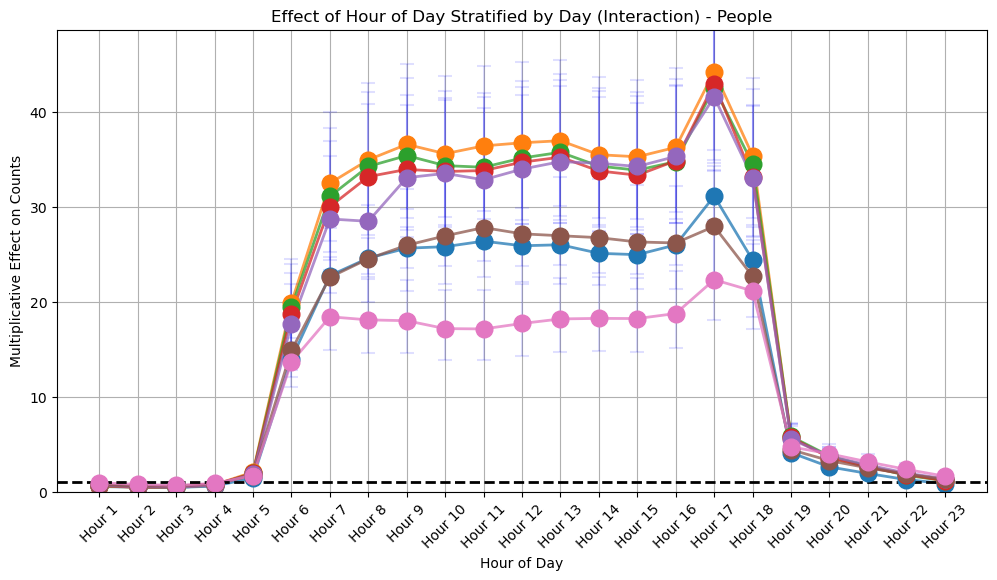

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to plot hour effects stratified by day of the week
def plot_hour_effects_by_day(model_df, hour_labels, title, site, super_category, show_whiskers=True):
    plt.figure(figsize=(12, 6))

    # Days of the week mapping (assuming 1 = Monday, 2 = Tuesday, etc.)
    days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    all_estimates = []  # List to keep track of all estimates across all days

    for day_idx, day in enumerate(days_of_week, start=1):
        estimates = []
        lower_bounds = []
        upper_bounds = []
        hour_indices = []

        if day == 'Mon':
            # For Monday, use the main effects
            for hour in range(1, 24):
                term = f'hour{hour}'
                row = model_df[model_df['term'] == term]
                if not row.empty:
                    coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
                    estimates.append(coef)
                    lower_bounds.append(lower)
                    upper_bounds.append(upper)
                    hour_indices.append(hour-1)  # Store hour index for connecting lines
                else:
                    # Handle missing data
                    estimates.append(np.nan)
                    lower_bounds.append(np.nan)
                    upper_bounds.append(np.nan)
                    hour_indices.append(hour-1)  # Maintain hour index for consistency
        else:
            # For other days, combine main effects with interaction effects
            for hour in range(1, 24):
                main_term = f'hour{hour}'
                inter_term = f'hour{hour}:day{day_idx}'
                
                main_row = model_df[model_df['term'] == main_term]
                inter_row = model_df[model_df['term'] == inter_term]
                
                if not main_row.empty and not inter_row.empty:
                    main_coef, main_lower, main_upper = calculate_effects_and_ci(main_row.iloc[0])
                    inter_coef, inter_lower, inter_upper = calculate_effects_and_ci(inter_row.iloc[0])
                    
                    # Combine estimates in log space
                    combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
                    combined_lower = np.exp(np.log(main_lower) + np.log(inter_lower))
                    combined_upper = np.exp(np.log(main_upper) + np.log(inter_upper))
                    
                    estimates.append(combined_estimate)
                    lower_bounds.append(combined_lower)
                    upper_bounds.append(combined_upper)
                    hour_indices.append(hour-1)  # Store hour index for connecting lines
                else:
                    # Handle missing data
                    estimates.append(np.nan)
                    lower_bounds.append(np.nan)
                    upper_bounds.append(np.nan)
                    hour_indices.append(hour-1)  # Maintain hour index for consistency

        # Convert lists to numpy arrays and remove any NaN values before plotting
        estimates = np.array(estimates)
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)
        hour_indices = np.array(hour_indices)  # Convert hour indices to numpy array
        
        valid_indices = ~np.isnan(estimates)
        
        estimates = estimates[valid_indices]
        lower_bounds = lower_bounds[valid_indices]
        upper_bounds = upper_bounds[valid_indices]
        valid_hour_indices = hour_indices[valid_indices]  # Filter hour indices to match valid estimates
        valid_hour_labels = np.array(hour_labels)[valid_indices]

        # Store all estimates for y-axis limit calculation
        all_estimates.extend(estimates)

        if len(estimates) > 0:
            if show_whiskers:
                plt.errorbar(
                    valid_hour_indices, 
                    estimates, 
                    yerr=[estimates - lower_bounds, upper_bounds - estimates], 
                    fmt='none', 
                    capsize=5,
                    alpha=0.125,  # Faint whiskers
                    elinewidth=1.5,
                    ecolor='blue',  # Default color for whiskers
                    errorevery=1,
                    capthick=1.5
                )
            
            # Plot the central points with full visibility
            plt.errorbar(
                valid_hour_indices, 
                estimates, 
                yerr=None,  # No whiskers here
                fmt='o', 
                capsize=5,
                label=f'Day: {day}',
                alpha=1.0,  # Fully visible central points
                markersize=12,
                elinewidth=1.5,
                errorevery=1,
                capthick=1.5
            )
            
            # Plot lines connecting points
            plt.plot(
                valid_hour_indices, 
                estimates, 
                linestyle='-', 
                color=plt.gca().lines[-1].get_color(),  # Use the same color as the points
                alpha=0.75,  # Slightly transparent line
                linewidth=2
            )

    # Adding a thicker black line at y=1 to represent the reference level
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    
    # Adjust y-axis limit to focus on the central tendency
    if all_estimates:
        max_estimate = max(all_estimates)
        plt.ylim(0, max_estimate * 1.1)  # Set the upper limit to 1.1 times the max estimate

    plt.xticks(ticks=range(len(valid_hour_labels)), labels=valid_hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Create directory if it doesn't exist
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_hour_by_day.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for site in sites:  # Loop over each site
    for super_category in super_categories:
        
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if os.path.exists(filepath):
            model_df = pd.read_csv(filepath)
            
            hour_labels = [f'Hour {i}' for i in range(1, 24)]
            
            # Plot the effects of hour stratified by day of the week
            plot_hour_effects_by_day(
                model_df, 
                hour_labels,
                f'Effect of Hour of Day Stratified by Day (Interaction) - {super_category.capitalize()}',
                site,
                super_category,
                show_whiskers=True  # Turn whiskers on or off
            )


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import r2_score
from tqdm import tqdm

# Function to calculate R² values across folds
def calculate_r2_across_folds(true_values, predicted_values):
    r2_values = []
    for true, predicted in zip(true_values, predicted_values):
        r2_values.append(r2_score(true, predicted))
    return r2_values

# Function to plot true vs predicted values for a site and super category
def plot_true_vs_predicted(site, super_category, true_values, predicted_values, title, output_dir):
    plt.figure(figsize=(8, 8))
    
    # Plotting each fold with different colors and lower alpha for transparency
    for i, (true, predicted) in enumerate(zip(true_values, predicted_values), start=1):
        plt.scatter(true, predicted, label=f'Fold {i}', alpha=0.3, s=20)  # Lower alpha for better visibility
    
    # Plotting the x=y reference line
    min_val = min(min([min(t) for t in true_values]), min([min(p) for p in predicted_values]))
    max_val = max(max([max(t) for t in true_values]), max([max(p) for p in predicted_values]))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    # Calculating R² values
    all_true = np.concatenate(true_values)
    all_predicted = np.concatenate(predicted_values)
    overall_r2 = r2_score(all_true, all_predicted)
    fold_r2_values = calculate_r2_across_folds(true_values, predicted_values)
    
    # Annotating the plot with R² values
    plt.text(0.05, 0.95, f'Overall R²: {overall_r2:.2f}\n'
                         f'Min R²: {min(fold_r2_values):.2f}\n'
                         f'Mean R²: {np.mean(fold_r2_values):.2f}\n'
                         f'Max R²: {max(fold_r2_values):.2f}', 
             fontsize=12, verticalalignment='top', transform=plt.gca().transAxes)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 0))  # Adjust legend location to avoid overlap with R² text
    plt.grid(True)
    
    # Ensuring the plot is on the same scale
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])
    
    # Save the figure
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}.png', bbox_inches='tight')
    plt.close()

# Main function to process all folds and plot results
def process_and_plot(site, super_category, folds_dir, output_dir):
    true_values_fixed_only = []
    predicted_values_fixed_only = []
    true_values_with_random = []
    predicted_values_with_random = []
    
    for fold in range(1, 6):
        file_path = f'{folds_dir}/interaction_fold_{fold}/{site}_{super_category}_fold_{fold}_model_predictions.csv'
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            true_values_fixed_only.append(data[f'{super_category}_counts'].values)
            predicted_values_fixed_only.append(data['predicted_counts_fixed_only'].values)
            true_values_with_random.append(data[f'{super_category}_counts'].values)
            predicted_values_with_random.append(data['predicted_counts_with_random'].values)
    
    if true_values_fixed_only and predicted_values_fixed_only:
        # Plot for fixed-only effects
        plot_true_vs_predicted(site, super_category, true_values_fixed_only, predicted_values_fixed_only, 
                               f'True vs Predicted (Fixed Effects Only) - {super_category.capitalize()}', 
                               f'{output_dir}/{site}/{super_category}')
        
    if true_values_with_random and predicted_values_with_random:
        # Plot for fixed and random effects
        plot_true_vs_predicted(site, super_category, true_values_with_random, predicted_values_with_random, 
                               f'True vs Predicted (Fixed and Random Effects) - {super_category.capitalize()}', 
                               f'{output_dir}/{site}/{super_category}')

# Example usage:
output_directory = './results/time_series'
folds_directory = './'

# Assuming you have site names and super categories
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for site in tqdm(sites):
    for super_category in super_categories:
        process_and_plot(site, super_category, folds_directory, output_directory)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.28s/it]


In [4]:
import pandas as pd
import numpy as np

# Function to calculate the central coefficient (estimate)
def calculate_effects(row):
    return row['estimate']

# Function to normalize the data array, now handling NaN by converting it to -1
def normalize_array(array):
    """Normalize each row of the array to be between 0 and 1, handling NaNs by setting them to -1."""
    array_min = np.nanmin(array, axis=1, keepdims=True)  # Find min for each row, ignoring NaN
    array_max = np.nanmax(array, axis=1, keepdims=True)  # Find max for each row, ignoring NaN
    
    # Handle edge cases where min == max (which would produce NaNs)
    normalized_array = (array - array_min) / (array_max - array_min)
    
    # Where original values were NaN, replace the normalized result with -1
    normalized_array[np.isnan(array)] = -1
    
    return normalized_array

# Function to combine main and interaction effects (for hour and day)
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef = calculate_effects(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef = calculate_effects(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
    else:
        combined_estimate = main_coef
    
    return combined_estimate

# Function to create data arrays for each time unit, handling missing terms
def create_data_array_for_time_unit(model_df, time_vars, site, super_category, time_unit):
    site_data = [1]  # Start with the reference class (set to 1)
    
    for time_var in time_vars:
        if time_unit == 'hour':
            # Extract the total hour effects (without averaging)
            main_term = f'hour{time_var[4:]}'  # Assuming time_var is in format 'hourX'
            main_row = model_df[model_df['term'] == main_term]
            
            if main_row.empty:
                site_data.append(np.nan)
            else:
                site_data.append(calculate_effects(main_row.iloc[0]))
                
        elif time_unit == 'day':
            # Extract the total day effects using hour interaction effects
            day_idx = int(time_var[3:])
            if day_idx == 1:
                site_data.append(1)  # Monday as reference
            else:
                main_term = f'day{day_idx}'
                main_row = model_df[model_df['term'] == main_term]
                interaction_estimates = []
                
                for hour in range(1, 24):
                    interaction_term = f'hour{hour}:day{day_idx}'
                    interaction_row = model_df[model_df['term'] == interaction_term]
                    
                    if not main_row.empty and not interaction_row.empty:
                        combined_effect = combine_main_and_interaction_effects(main_row.iloc[0], interaction_row)
                        interaction_estimates.append(combined_effect)
                
                if interaction_estimates:
                    avg_estimate = np.mean(interaction_estimates)
                    site_data.append(avg_estimate)
                else:
                    site_data.append(np.nan)
                
        elif time_unit in ['week', 'year']:
            # Extract the central coefficient for week or year
            row = model_df[model_df['term'] == time_var]
            
            if row.empty:
                site_data.append(np.nan)
            else:
                site_data.append(calculate_effects(row.iloc[0]))
    
    return site_data

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

# Define time unit labels for hour, day, week, and year
time_unit_definitions = {
    'hour': [f'hour{i}' for i in range(1, 24)],  # 24 hours in a day
    'day': [f'day{i}' for i in range(2, 8)],  # 7 days in a week (assuming day1 is reference)
    'week': [f'week{i}' for i in range(2, 53)],  # 52 weeks in a year (Week 1 assumed to be reference)
    'year': [f'year{i}' for i in range(2020, 2025)]  # Assuming 2019 is the reference year
}

for super_category in super_categories:
    for time_unit, time_vars in time_unit_definitions.items():
        data_array_all_sites = []
        
        for site in sites:
            # Load model data for the current site and supercategory
            model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
            
            # Create a data array for this site and time unit
            data_array = create_data_array_for_time_unit(model_df, time_vars, site, super_category, time_unit)
            
            # Append the normalized data for this site
            data_array_all_sites.append(data_array)
        
        # Convert list to NumPy array
        data_array_all_sites = np.array(data_array_all_sites)
        
        # Normalize the data array row-wise
        normalized_data_array = normalize_array(data_array_all_sites)
        
        # Print the results
        print(f"Object Category: {super_category}, Time Unit: {time_unit}")
        for site, row in zip(sites, normalized_data_array):
            print(f"{site}: {row}")
        print("\n" + "-"*40 + "\n")



Object Category: people, Time Unit: hour
AD: [1.81386965e-02 3.01597442e-03 1.09922456e-04 0.00000000e+00
 4.06608864e-03 3.32412906e-02 4.40864580e-01 7.26982926e-01
 7.87119891e-01 8.21086444e-01 8.26323876e-01 8.45321768e-01
 8.29401371e-01 8.32881090e-01 8.03568843e-01 7.98852178e-01
 8.32362111e-01 1.00000000e+00 7.80339487e-01 1.18977469e-01
 7.02980464e-02 4.76221923e-02 2.67113435e-02 1.29830531e-02]
ASH: [0.03183743 0.00425565 0.         0.00156371 0.00183149 0.06959906
 0.44182557 0.74690035 0.79222408 0.70078619 0.7484442  0.66306572
 0.58692775 0.53118435 0.52253827 0.72047124 0.9120717  1.
 0.92582394 0.46635791 0.38040467 0.27256819 0.16252082 0.05846725]
EL: [6.95696948e-02 2.29647080e-02 8.81497824e-03 0.00000000e+00
 6.97737013e-04 3.53770179e-02 5.46177243e-01 9.53985259e-01
 7.90006203e-01 6.78873024e-01 6.47017728e-01 7.16128140e-01
 7.28670445e-01 7.03666458e-01 7.32122760e-01 8.22792271e-01
 8.66913269e-01 1.00000000e+00 8.64241688e-01 3.51821105e-01
 2.41238760e-

In [5]:
import pandas as pd
import numpy as np

# Function to calculate the central coefficient (estimate)
def calculate_effects(row):
    return row['estimate']

# Function to normalize the data array, now handling NaN by converting it to -1
def normalize_array(array):
    """Normalize each row of the array to be between 0 and 1, handling NaNs by setting them to -1."""
    array_min = np.nanmin(array, axis=1, keepdims=True)  # Find min for each row, ignoring NaN
    array_max = np.nanmax(array, axis=1, keepdims=True)  # Find max for each row, ignoring NaN
    
    # Handle edge cases where min == max (which would produce NaNs)
    normalized_array = (array - array_min) / (array_max - array_min)
    
    # Where original values were NaN, replace the normalized result with -1
    normalized_array[np.isnan(array)] = -1
    
    return normalized_array

# Function to combine main and interaction effects (for hour and day)
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef = calculate_effects(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef = calculate_effects(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
    else:
        combined_estimate = main_coef
    
    return combined_estimate

# Function to create data arrays for each time unit, handling missing terms
def create_data_array_for_time_unit(model_df, time_vars, site, super_category, time_unit):
    site_data = [1]  # Start with the reference class (set to 1)
    
    for time_var in time_vars:
        if time_unit == 'hour':
            # Extract the total hour effects (without averaging)
            main_term = f'hour{time_var[4:]}'  # Assuming time_var is in format 'hourX'
            main_row = model_df[model_df['term'] == main_term]
            
            if main_row.empty:
                site_data.append(np.nan)
            else:
                site_data.append(calculate_effects(main_row.iloc[0]))
                
        elif time_unit == 'day':
            # Extract the total day effects using hour interaction effects
            day_idx = int(time_var[3:])
            if day_idx == 1:
                site_data.append(1)  # Monday as reference
            else:
                main_term = f'day{day_idx}'
                main_row = model_df[model_df['term'] == main_term]
                interaction_estimates = []
                
                for hour in range(1, 24):
                    interaction_term = f'hour{hour}:day{day_idx}'
                    interaction_row = model_df[model_df['term'] == interaction_term]
                    
                    if not main_row.empty and not interaction_row.empty:
                        combined_effect = combine_main_and_interaction_effects(main_row.iloc[0], interaction_row)
                        interaction_estimates.append(combined_effect)
                
                if interaction_estimates:
                    avg_estimate = np.mean(interaction_estimates)
                    site_data.append(avg_estimate)
                else:
                    site_data.append(np.nan)
                
        elif time_unit in ['week', 'year']:
            # Extract the central coefficient for week or year
            row = model_df[model_df['term'] == time_var]
            
            if row.empty:
                site_data.append(np.nan)
            else:
                site_data.append(calculate_effects(row.iloc[0]))
    
    return site_data

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

# Define time unit labels for hour, day, week, and year
time_unit_definitions = {
    'hour': [f'hour{i}' for i in range(1, 24)],  # 24 hours in a day
    'day': [f'day{i}' for i in range(2, 8)],  # 7 days in a week (assuming day1 is reference)
    'week': [f'week{i}' for i in range(2, 53)],  # 52 weeks in a year (Week 1 assumed to be reference)
    'year': [f'year{i}' for i in range(2020, 2025)]  # Assuming 2019 is the reference year
}

# Initialize the dictionary to store normalized arrays for each super_category and time_unit
normalized_data_arrays = {}

# Iterate over super_categories and time_units
for super_category in super_categories:
    normalized_data_arrays[super_category] = {}  # Create an entry for each super_category
    
    for time_unit, time_vars in time_unit_definitions.items():
        data_array_all_sites = []
        
        for site in sites:
            # Load model data for the current site and supercategory
            model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
            
            # Create a data array for this site and time unit
            data_array = create_data_array_for_time_unit(model_df, time_vars, site, super_category, time_unit)
            
            # Append the data for this site
            data_array_all_sites.append(data_array)
        
        # Convert list to NumPy array
        data_array_all_sites = np.array(data_array_all_sites)
        
        # Normalize the data array row-wise
        normalized_data_array = normalize_array(data_array_all_sites)
        
        # Store the normalized array in the dictionary
        normalized_data_arrays[super_category][time_unit] = normalized_data_array

# The "normalized_data_arrays" variable now contains the normalized arrays for each super_category and time_unit


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import spearmanr
import pymannkendall as mk  # Mann-Kendall test library

# Create the output directory if it doesn't exist
output_dir = "results/time_series_by_time"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the manual x-axis labels for each time unit
x_labels_definitions = {
    'hour': [f'{i}' for i in range(1, 24)],  # 23 hours in a day, starting with '1'
    'day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  # Days of the week starting with Monday
    'week': [f'{i}' for i in range(1, 53)],  # 52 weeks in a year, starting with '1'
    'year': [f'{i}' for i in range(2019, 2025)]  # Years from 2019 to 2024
}

# Function to perform Spearman or Mann-Kendall trend detection
def check_trend(row, method='spearman'):
    year_values = np.arange(5)  # Encode year as [0, 1, 2, 3, 4] for 2019–2023
    row_subset = row[:5]  # Use only the first 5 values (2019–2023)

    if method == 'spearman':
        # Perform Spearman correlation and return trend direction
        corr, p_value = spearmanr(year_values, row_subset)
        if p_value < (0.05 / 70):  # Bonferroni correction applied
            if corr > 0:
                return 'up'  # Positive correlation
            elif corr < 0:
                return 'down'  # Negative correlation
    elif method == 'mannkendall':
        # Perform Mann-Kendall test and return trend direction
        mk_result = mk.original_test(row_subset)
        if mk_result.p < (0.05/70):  # Bonferroni correction applied
            print(mk_result.p)
            if mk_result.trend == 'increasing':
                return 'up'
            elif mk_result.trend == 'decreasing':
                return 'down'
    return None

# Function to plot heatmaps
def plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories, trend_method='spearman'):
    num_sites = len(sites)
    num_time_vars = len(x_labels_definitions[time_unit])  # Get the correct number of labels from the x-axis definition

    # Adjust the grid layout based on the time_unit
    if time_unit in ['day', 'year']:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 grid for day and year
    else:
        fig, axes = plt.subplots(3, 3, figsize=(1.5 * num_time_vars, 0.6 * num_sites * 3))  # 3x3 grid for hour and week

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the heatmaps for each object category (7 subplots)
    for idx, super_category in enumerate(super_categories):
        if super_category in data_arrays and time_unit in data_arrays[super_category]:
            heatmap_data = data_arrays[super_category][time_unit]

            if heatmap_data.size > 0:  # Ensure data is not empty
                sns.heatmap(
                    heatmap_data, ax=axes[idx], cmap="bwr", vmin=0, vmax=1,  # Use fixed range 0-1 for colormap
                    cbar=False,  # No colorbar as requested
                    xticklabels=x_labels_definitions[time_unit], yticklabels=sites,  # Ensure correct labels
                    square=False  # Adjust square=False for dynamic subplot sizes
                )
                axes[idx].set_title(super_category.replace('_', ' ').capitalize(), fontsize=14)
                axes[idx].set_xlabel(time_unit.capitalize(), fontsize=12)
                axes[idx].set_ylabel("Sites", fontsize=12)

                # If the time unit is 'year', check for trend (Spearman or Mann-Kendall) and annotate
                if time_unit == 'year':
                    for row_idx, row in enumerate(heatmap_data):
                        trend = check_trend(row, method=trend_method)
                        if trend == 'up':
                            axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▲', color='red', fontsize=14, va='center', ha='center')
                        elif trend == 'down':
                            axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▼', color='blue', fontsize=14, va='center', ha='center')

    # Turn off the last two empty subplots for 3x3 and the last one for 2x4
    if time_unit in ['day', 'year']:
        for ax in axes[7:]:
            ax.axis('off')  # Turn off the last subplot in 2x4 grid
    else:
        for ax in axes[len(super_categories):]:
            ax.axis('off')  # Turn off the last two subplots in 3x3 grid

    # Adjust the layout and title for each time unit
    plt.suptitle(f"Heatmaps for {time_unit.capitalize()} across Object Categories", fontsize=18, y=1.02)
    plt.tight_layout(pad=1.0)

    # Save the figure to the output directory
    output_path = os.path.join(output_dir, f"{time_unit}_heatmaps_{trend_method}.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()

# Example: Assuming normalized data arrays are already created and stored in "normalized_data_arrays"
# We can specify either 'spearman' or 'mannkendall' when calling the plot function
for time_unit in ['year']:
    plot_heatmaps_for_time_unit(normalized_data_arrays, time_unit, sites, super_categories, trend_method='spearman')


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import spearmanr
import pymannkendall as mk  # Mann-Kendall test library
from scipy.stats import wilcoxon  # Import Wilcoxon test

# Function to calculate year-on-year differences and perform the Wilcoxon Signed-Rank Test
def check_trend(row, method='spearman'):
    year_values = np.arange(5)  # Encode year as [0, 1, 2, 3, 4] for 2019–2023
    row_subset = row[:5]  # Use only the first 5 values (2019–2023)
    
    if method == 'spearman':
        # Perform Spearman correlation and return trend direction
        corr, p_value = spearmanr(year_values, row_subset)
        if p_value < (0.05 / 70):  # Bonferroni correction applied
            if corr > 0:
                return 'up'  # Positive correlation
            elif corr < 0:
                return 'down'  # Negative correlation

    elif method == 'mannkendall':
        # Perform Mann-Kendall test and return trend direction
        mk_result = mk.original_test(row_subset)
        if mk_result.p < (0.05/70):  # Bonferroni correction applied
            if mk_result.trend == 'increasing':
                return 'up'
            elif mk_result.trend == 'decreasing':
                return 'down'
    
    elif method == 'wilcoxon':
        # Step 1: Calculate year-on-year differences (Y_n+1 - Y_n)
        year_on_year_diff = np.diff(row_subset)
        
        # Step 2: Perform Wilcoxon Signed-Rank Test on the differences
        # Handling zero differences using 'pratt', and using 'exact' method for small samples
        wilcoxon_stat, p_value = wilcoxon(year_on_year_diff, zero_method='pratt', alternative='two-sided', method='exact')
        
        if p_value < (0.05 / 70):  # Bonferroni correction applied
            # Step 3: Calculate the average year-on-year difference
            avg_diff = np.mean(year_on_year_diff)
            if avg_diff > 0:
                return 'up', avg_diff  # Positive trend, return direction and average difference
            elif avg_diff < 0:
                return 'down', avg_diff  # Negative trend, return direction and average difference

    return None

# Modify plot_heatmaps_for_time_unit to annotate arrows and the average year-on-year change
def plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories, trend_method='spearman'):
    num_sites = len(sites)
    num_time_vars = len(x_labels_definitions[time_unit])  # Get the correct number of labels from the x-axis definition

    # Adjust the grid layout based on the time_unit
    if time_unit in ['day', 'year']:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 grid for day and year
    else:
        fig, axes = plt.subplots(3, 3, figsize=(1.5 * num_time_vars, 0.6 * num_sites * 3))  # 3x3 grid for hour and week

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the heatmaps for each object category (7 subplots)
    for idx, super_category in enumerate(super_categories):
        if super_category in data_arrays and time_unit in data_arrays[super_category]:
            heatmap_data = data_arrays[super_category][time_unit]

            if heatmap_data.size > 0:  # Ensure data is not empty
                sns.heatmap(
                    heatmap_data, ax=axes[idx], cmap="bwr", vmin=0, vmax=1,  # Use fixed range 0-1 for colormap
                    cbar=False,  # No colorbar as requested
                    xticklabels=x_labels_definitions[time_unit], yticklabels=sites,  # Ensure correct labels
                    square=False  # Adjust square=False for dynamic subplot sizes
                )
                axes[idx].set_title(super_category.replace('_', ' ').capitalize(), fontsize=14)
                axes[idx].set_xlabel(time_unit.capitalize(), fontsize=12)
                axes[idx].set_ylabel("Sites", fontsize=12)

                # If the time unit is 'year', check for trend (Spearman, Mann-Kendall, or Wilcoxon) and annotate
                if time_unit == 'year':
                    for row_idx, row in enumerate(heatmap_data):
                        trend = check_trend(row, method=trend_method)
                        if trend:
                            if trend_method == 'wilcoxon':
                                trend_direction, avg_diff = trend  # Get both direction and average difference
                                arrow = '▲' if trend_direction == 'up' else '▼'
                                color = 'red' if trend_direction == 'up' else 'blue'
                                # Annotate with arrow and average difference
                                axes[idx].text(len(row) + 0.5, row_idx + 0.5, f'{arrow} {avg_diff:.2f}', color=color, fontsize=14, va='center', ha='center')
                            else:
                                if trend == 'up':
                                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▲', color='red', fontsize=14, va='center', ha='center')
                                elif trend == 'down':
                                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▼', color='blue', fontsize=14, va='center', ha='center')

    # Turn off the last two empty subplots for 3x3 and the last one for 2x4
    if time_unit in ['day', 'year']:
        for ax in axes[7:]:
            ax.axis('off')  # Turn off the last subplot in 2x4 grid
    else:
        for ax in axes[len(super_categories):]:
            ax.axis('off')  # Turn off the last two subplots in 3x3 grid

    # Adjust the layout and title for each time unit
    plt.suptitle(f"Heatmaps for {time_unit.capitalize()} across Object Categories", fontsize=18, y=1.02)
    plt.tight_layout(pad=1.0)

    # Save the figure to the output directory
    output_path = os.path.join(output_dir, f"{time_unit}_heatmaps_{trend_method}.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()


# Example: Assuming normalized data arrays are already created and stored in "normalized_data_arrays"
# We can specify either 'spearman' or 'mannkendall' when calling the plot function
for time_unit in ['year']:
    plot_heatmaps_for_time_unit(normalized_data_arrays, time_unit, sites, super_categories, trend_method='wilcoxon')


/tmp/ipykernel_385/689644297.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_categories_avg))


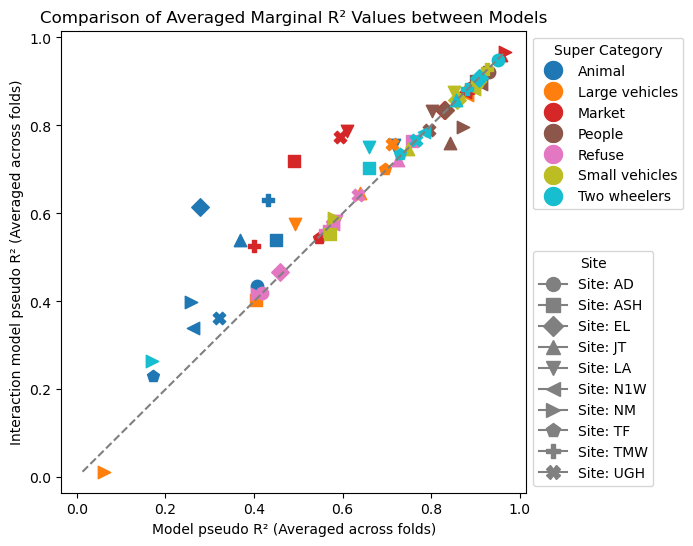

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Load the CSV files
interaction_pseudo_r2_path = './MODEL_RESULTS/interaction_pseudo_r2_results.csv'
pseudo_r2_path = './MODEL_RESULTS/pseudo_r2_results.csv'

# Read both CSV files
interaction_pseudo_r2_df = pd.read_csv(interaction_pseudo_r2_path)
pseudo_r2_df = pd.read_csv(pseudo_r2_path)

# Group by "site" and "super_category" and calculate the average marginal_R2 across folds
interaction_avg_df = interaction_pseudo_r2_df.groupby(['site', 'super_category']).agg(
    avg_marginal_R2_interaction=('marginal_R2', 'mean')).reset_index()

pseudo_r2_avg_df = pseudo_r2_df.groupby(['site', 'super_category']).agg(
    avg_marginal_R2=('marginal_R2', 'mean')).reset_index()

# Merge the two datasets based on "site" and "super_category"
merged_avg_df = pd.merge(interaction_avg_df, pseudo_r2_avg_df, on=['site', 'super_category'])

# Prepare the data for plotting
interaction_values_avg = merged_avg_df['avg_marginal_R2_interaction']
pseudo_r2_values_avg = merged_avg_df['avg_marginal_R2']
categories_avg = merged_avg_df['super_category'].str.replace('_', ' ').str.capitalize()
sites_avg = merged_avg_df['site']

# Create the plot
plt.figure(figsize=(6, 6))

# Use colors for super_category and markers for site
unique_sites_avg = sites_avg.unique()
unique_categories_avg = categories_avg.unique()
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', 'X']  # Markers for different sites
colors = plt.cm.get_cmap('tab10', len(unique_categories_avg))

# Create separate legends for super_category and site
for i, category in enumerate(unique_categories_avg):
    category_mask = (categories_avg == category)
    for j, site in enumerate(unique_sites_avg):
        site_mask = (sites_avg == site)
        combined_mask = category_mask & site_mask
        if combined_mask.sum() > 0:  # Only plot if there are values
            plt.scatter(pseudo_r2_values_avg[combined_mask], interaction_values_avg[combined_mask], 
                        color=colors(i), marker=markers[j % len(markers)], 
                        edgecolors=None, s = 80)

# Add the dashed x=y reference line
x_vals = np.linspace(min(pseudo_r2_values_avg.min(), interaction_values_avg.min()), 
                     max(pseudo_r2_values_avg.max(), interaction_values_avg.max()), 100)
plt.plot(x_vals, x_vals, '--', color='gray')

# Add axis labels and title
plt.xlabel("Model pseudo R² (Averaged across folds)")
plt.ylabel("Interaction model pseudo R² (Averaged across folds)")
plt.title("Comparison of Averaged Marginal R² Values between Models")

# Create legends for super_category and site
# Custom legend for super_category (colors)
super_category_legend = [Line2D([0], [0], marker='o', color='w', label=f'{cat}', 
                                markerfacecolor=colors(i), markersize=15, markeredgecolor=None) 
                         for i, cat in enumerate(unique_categories_avg)]

# Custom legend for sites (marker styles)
site_legend = [Line2D([0], [0], marker=markers[j % len(markers)], color='gray', label=f'Site: {site}', 
                      markersize=10, markeredgecolor=None) 
               for j, site in enumerate(unique_sites_avg)]

# Add the legends
first_legend = plt.legend(handles=site_legend, title="Site", loc='lower left', bbox_to_anchor=(1, 0))
plt.gca().add_artist(first_legend)  # Add the first legend separately
plt.legend(handles=super_category_legend, title="Super Category", loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure with bbox_inches='tight' to prevent legend cropping
# plt.tight_layout()
plt.savefig('./results/scatter_plot_avg_with_legend.png', bbox_inches='tight')

# Show the plot
plt.show()